**Daten laden & Basis mit verspäteter Ankunft**

In [15]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
# from scipy import stats  # <- nur für Block 7 nötig, sonst weglassen

sns.set_theme(style="whitegrid")

# Daten laden (nur falls df noch nicht existiert)
if "df" not in globals():
    for p in [Path("../data/processed/istdata_clean.parquet"),
              Path("../data/processed/istdata_real_2025-09.parquet")]:
        if p.exists():
            df = pd.read_parquet(p)
            print("Datenquelle:", p)
            break
    else:
        raise FileNotFoundError("Keine Parquet-Datei gefunden.")
    if "delay_arrival_min" not in df and "delay_arrival_s" in df:
        df["delay_arrival_min"] = df["delay_arrival_s"]/60
    df = df.dropna(subset=["delay_arrival_min"]).copy()

x = df["delay_arrival_min"].astype(float)

**Erwartungswert, Median, Varianz, IQR (+ kompakte Verteilung)**

Mean: 1.524  | Median: 1.150
Std:  4.948   | Var:    24.484
Q25:  0.400   | Q75:    2.167  | IQR: 1.767


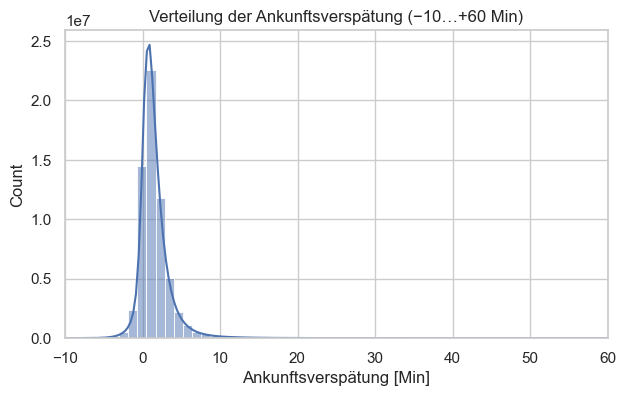

In [16]:
# Kennzahlen
mean  = x.mean()
median= x.median()
var_  = x.var(ddof=1)
std   = x.std(ddof=1)
q25, q75 = x.quantile([.25,.75])
iqr = q75 - q25

print(f"Mean: {mean:.3f}  | Median: {median:.3f}")
print(f"Std:  {std:.3f}   | Var:    {var_:.3f}")
print(f"Q25:  {q25:.3f}   | Q75:    {q75:.3f}  | IQR: {iqr:.3f}")

# Verteilung (Zoom für Lesbarkeit)
x_zoom = x[(x>-10)&(x<60)]
plt.figure(figsize=(7,4))
sns.histplot(x_zoom, bins=60, kde=True)
plt.xlim(-10,60); plt.xlabel("Ankunftsverspätung [Min]")
plt.title("Verteilung der Ankunftsverspätung (−10…+60 Min)")
plt.show()

**Interpretation:**
Hier werden die zentralen Kennzahlen der Verteilung bestimmt.
Der Mittelwert (Erwartungswert) beschreibt, wie sich die Verspätungen im Durchschnitt verhalten – er gibt das „statistische Gleichgewicht“ der Daten an.
Der Median teilt alle Werte in zwei Hälften: 50 % der Fahrten sind pünktlicher, 50 % später.
Der Vergleich von Mean und Median zeigt, ob die Daten symmetrisch oder schief verteilt sind.
Wenn der Mittelwert deutlich größer ist als der Median, liegt eine Rechtsschiefe vor – also viele kleine Verspätungen, aber einige sehr große Ausreißer, die den Durchschnitt nach oben ziehen.

Die Varianz und Standardabweichung messen die Streuung, also wie stark einzelne Werte vom Mittelwert abweichen.
Eine hohe Varianz zeigt, dass die Pünktlichkeit stark schwankt – z. B. durch unterschiedliche Linien oder Tageszeiten.
Der Interquartilsabstand (IQR) ist robuster gegen Ausreißer und zeigt die typische Schwankung der zentralen 50 % der Daten.

Der Histogramm-Plot veranschaulicht die empirische Häufigkeitsverteilung, also die beobachtete Wahrscheinlichkeit, dass eine Verspätung in einem bestimmten Bereich liegt.
Damit siehst du auf einen Blick, wie viele Fahrten leicht, stark oder gar nicht verspätet sind.

**Wahrscheinlichkeiten P(X>5) und P(X>15) + CDF**

P(X>5)  = 4.70%
P(X>15) = 0.32%


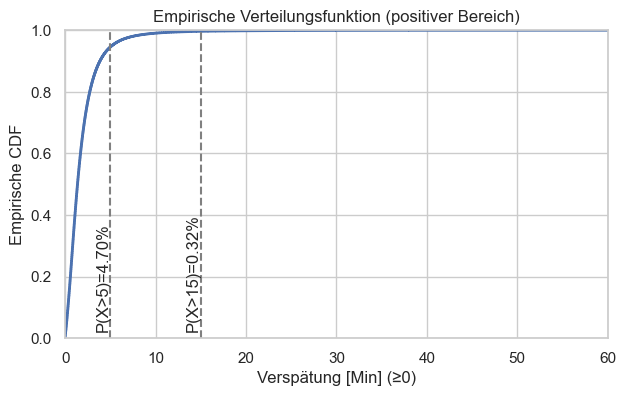

In [17]:
p_gt5  = (x > 5).mean()
p_gt15 = (x > 15).mean()
print(f"P(X>5)  = {p_gt5:.2%}")
print(f"P(X>15) = {p_gt15:.2%}")

# Empirische CDF (nur positive Verspätungen für klare Lesbarkeit)
pos = x[x>=0].sort_values().to_numpy()
if pos.size:
    cdf = np.arange(1, pos.size+1)/pos.size
    plt.figure(figsize=(7,4))
    plt.plot(pos, cdf, lw=2)
    for t, lab in [(5, f"P(X>{5})={p_gt5:.2%}"), (15, f"P(X>{15})={p_gt15:.2%}")]:
        plt.axvline(t, ls="--", color="gray")
        plt.text(t, 0.02, lab, rotation=90, va="bottom", ha="right")
    plt.xlim(0, max(60, np.percentile(pos,99)))
    plt.ylim(0,1)
    plt.xlabel("Verspätung [Min] (≥0)"); plt.ylabel("Empirische CDF")
    plt.title("Empirische Verteilungsfunktion (positiver Bereich)")
    plt.show()


**Interpretation:**
In diesem Schritt werden Wahrscheinlichkeiten abgeschätzt, mit denen eine Fahrt eine bestimmte Verspätung überschreitet.
Das entspricht der Wahrscheinlichkeitsverteilung einer Zufallsvariablen, hier:
X = \text{Verspätung in Minuten}.

Beispielsweise bedeutet P(X > 5), dass eine zufällig gewählte Fahrt eine Verspätung über fünf Minuten hat.
Die Werte stammen aus relativen Häufigkeiten, also der empirischen Annäherung an theoretische Wahrscheinlichkeiten.

Die empirische Verteilungsfunktion (CDF) zeigt, wie sich diese Wahrscheinlichkeiten aufsummieren:
Für jeden möglichen Verspätungswert x sieht man, wie groß die Wahrscheinlichkeit ist, dass eine Fahrt höchstens x Minuten verspätet ist.
Das ist ein zentrales Konzept der Statistik:
Aus der beobachteten Häufigkeit lässt sich auf kumulative Wahrscheinlichkeiten schließen.

So kannst du Aussagen treffen wie:

„95 % aller Fahrten kommen mit weniger als 10 Minuten Verspätung an.“


**Bedingte Wahrscheinlichkeit nach Wochentag (Werktag vs. Wochenende)**

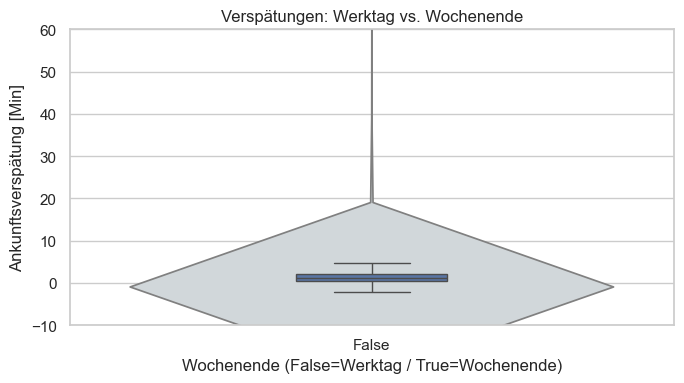

Mittelwert [Min]:
 is_weekend
False    1.524043
Name: delay_arrival_min, dtype: float64

KPIs [%]:
             gt5  gt15
is_weekend           
False       4.7  0.32


In [20]:
if "Wochentag" in df.columns:
    df["is_weekend"] = df["Wochentag"].isin(["Samstag","Sonntag"])

    # Verteilung (Violin + Box)
    fig, ax = plt.subplots(figsize=(7,4))
    sns.violinplot(data=df, x="is_weekend", y="delay_arrival_min", cut=0, inner=None, color="#cfd8dc", ax=ax)
    sns.boxplot   (data=df, x="is_weekend", y="delay_arrival_min", showfliers=False, width=0.25, ax=ax)
    ax.set_ylim(-10,60)
    ax.set_xlabel("Wochenende (False=Werktag / True=Wochenende)")
    ax.set_ylabel("Ankunftsverspätung [Min]")
    ax.set_title("Verspätungen: Werktag vs. Wochenende")
    plt.tight_layout(); plt.show()

    # Kennzahlen & KPIs
    means = df.groupby("is_weekend", observed=True)["delay_arrival_min"].mean()
    kpis  = df.assign(gt5 = df["delay_arrival_min"]>5, gt15 = df["delay_arrival_min"]>15) \
                .groupby("is_weekend", observed=True)[["gt5","gt15"]].mean()*100
    print("Mittelwert [Min]:\n", means)
    print("\nKPIs [%]:\n", kpis.round(2))
else:
    print("Spalte 'Wochentag' nicht gefunden.")


**Interpretation:**
Hier wird untersucht, ob sich die Verteilung der Verspätungen zwischen zwei Gruppen unterscheidet.
Das ist ein klassisches Beispiel für eine bedingte Analyse:
Man betrachtet die Zufallsvariable (Verspätung) unter einer Bedingung – entweder Werktag oder Wochenende.

Der Violinplot kombiniert Dichte- und Boxdarstellung, wodurch man sowohl die Form der Verteilung als auch Median, Quartile und Streuung sieht.
Dadurch erkennst du sofort, ob die Verteilungen in Lage (Mittelwert) oder Form (Streuung, Schiefe) voneinander abweichen.

Die Bedeutung für die Statistik:
Solche Vergleiche sind der erste Schritt in Richtung Inferenzstatistik – also der Frage, ob beobachtete Unterschiede systematisch oder zufällig sind.
Auch wenn hier noch kein formaler Test gemacht wird, deutet eine klar andere Lage oder Streuung darauf hin, dass der Wochentag einen Einfluss auf die Verspätung haben könnte.

Die Kennzahlen P(X>5) und P(X>15) zeigen zusätzlich, wie sich die Wahrscheinlichkeit relevanter Verspätungen in den beiden Gruppen unterscheidet.
So wird die Statistik praktisch nutzbar:
Die Analyse quantifiziert, wie stark äußere Bedingungen (z. B. Fahrplanänderungen am Wochenende) das Verhalten der Zufallsvariablen beeinflussen.



**Produktvergleich**

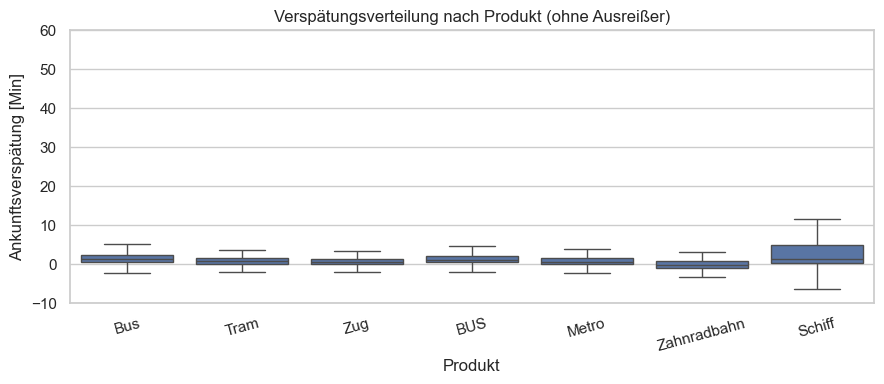

,mean_delay,p_gt5,n
PRODUKT_ID,,,
Zahnradbahn,-0.22,1.61,23042
Zug,0.85,2.18,4201912
Tram,1.07,2.59,6277269
BUS,1.43,3.07,2723244
Metro,1.53,8.23,115426
Bus,1.65,5.27,48590628
Schiff,2.77,24.19,9066


In [19]:
prod_col = next((c for c in ["product","PRODUKT_ID","PRODUKT_ID_CLEAN"] if c in df.columns), None)

if prod_col:
    order = df[prod_col].value_counts().index.tolist()

    plt.figure(figsize=(9,4))
    sns.boxplot(data=df, x=prod_col, y="delay_arrival_min", showfliers=False, order=order)
    plt.ylim(-10,60); plt.xticks(rotation=15)
    plt.xlabel("Produkt"); plt.ylabel("Ankunftsverspätung [Min]")
    plt.title("Verspätungsverteilung nach Produkt (ohne Ausreißer)")
    plt.tight_layout(); plt.show()

    # Mittelwerte + KPI >5 min
    comp = df.groupby(prod_col, observed=True).agg(
        mean_delay=("delay_arrival_min","mean"),
        p_gt5=("delay_arrival_min", lambda s: (s>5).mean()*100),
        n=("delay_arrival_min","size")
    ).sort_values("mean_delay")
    display(comp.round(2).head(10))
else:
    print("Keine Produktspalte gefunden.")


**Interpretation:**
Hier werden mehrere Kategorien gleichzeitig verglichen – ein typisches Beispiel für eine mehrstufige Gruppierung.
Jede Produktart bildet eine eigene Stichprobe derselben Zufallsvariablen (Verspätung).

Die Boxplots zeigen Median, Quartile und Ausreißer jeder Gruppe.
So erkennt man nicht nur, welche Produktart im Mittel pünktlicher ist, sondern auch, wo die Streuung besonders groß ist.
Der Boxplot ist ein robustes Lage- und Streuungsdiagramm – eine der wichtigsten grafischen Methoden der beschreibenden Statistik.

Die zusätzlichen Kennzahlen in der Tabelle (Mittelwert, Anteil > 5 Minuten, Stichprobengröße n) ermöglichen eine quantitative Bewertung der Unterschiede.
Dadurch kannst du entscheiden, ob beobachtete Differenzen auch statistisch relevant sind oder nur auf ungleiche Gruppengrößen zurückgehen.

Inhaltlich zeigt die Analyse:
	•	Welche Transportmittel tendenziell zuverlässiger sind.
	•	Ob die Varianz (also die Unsicherheit) innerhalb einzelner Produktarten unterschiedlich groß ist.

Das ist ein direktes Beispiel für den statistischen Grundsatz der Datenstratifizierung, bei der heterogene Daten in homogene Teilgruppen zerlegt werden, um Muster zu erkennen.



**Betreiber-Benchmark**

Top-5 pünktlichste Betreiber:


,mean_delay,p_gt5,n
BETREIBER_NAME,,,
Gornergratbahn,-0.84,0.10,8085
Appenzeller Bahnen (ab),-0.76,2.79,135260
Jungfraubahn,-0.57,3.82,2618
Regionalverkehr Bern-Solothurn,0.15,0.37,129410
Transports de Martigny et Régions (mc),0.23,0.35,11462



Top-5 unpünktlichste Betreiber:


,mean_delay,p_gt5,n
BETREIBER_NAME,,,
Mouettes genevoises SA,2.77,24.19,9066
Transports Publics Neuchâtelois SA (tn),3.13,17.06,563692
DB ZugBus Regionalverkehr Alb-Bodensee,3.60,17.71,1005
Trasporti Pubblici Luganesi SA,3.64,21.09,751283
Appenzeller Bahnen Ersatzverkehr,4.62,40.01,2142


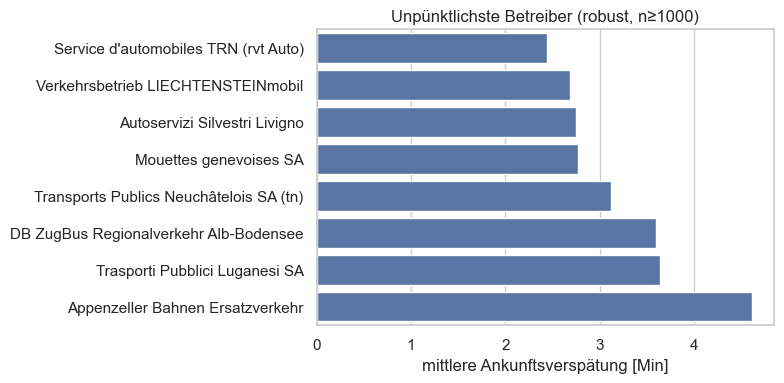

In [21]:
if "BETREIBER_NAME" in df.columns:
    counts = df["BETREIBER_NAME"].value_counts()
    keep = counts[counts >= 1000].index  # Schwelle ggf. anpassen
    sub = df[df["BETREIBER_NAME"].isin(keep)]

    op = sub.groupby("BETREIBER_NAME", observed=True).agg(
        mean_delay=("delay_arrival_min","mean"),
        p_gt5=("delay_arrival_min", lambda s: (s>5).mean()*100),
        n=("delay_arrival_min","size")
    ).sort_values("mean_delay")

    print("Top-5 pünktlichste Betreiber:"); display(op.head(5).round(2))
    print("\nTop-5 unpünktlichste Betreiber:"); display(op.tail(5).round(2))

    worst = op.tail(8)
    plt.figure(figsize=(8,4))
    sns.barplot(y=worst.index, x=worst["mean_delay"].values, orient="h")
    plt.xlabel("mittlere Ankunftsverspätung [Min]"); plt.ylabel("")
    plt.title("Unpünktlichste Betreiber (robust, n≥1000)")
    plt.tight_layout(); plt.show()
else:
    print("Spalte 'BETREIBER_NAME' nicht vorhanden.")


**Interpretation:**
Diese Analyse basiert auf dem Konzept der Gruppenmittelwerte und ist ein praktischer Einsatz von deskriptiver Statistik für Qualitätsvergleiche.
Hier werden alle Werte nach Betreiber gruppiert und deren durchschnittliche Verspätung berechnet.
Mit einer Mindestanzahl (n ≥ 1000) wird die Stichprobenverzerrung kontrolliert – denn kleine Gruppen liefern keine stabilen Mittelwerte.

Die Top- und Flop-Listen zeigen systematische Unterschiede zwischen Unternehmen.
Statistisch gesehen handelt es sich um eine Schätzung der Lageparameter je Population – jede Betreibergruppe repräsentiert eine Teilpopulation.
Die Balkengrafik ist eine Visualisierung der Mittelwertvergleiche und erlaubt, extreme Ausreißer schnell zu identifizieren.

Interpretativ bedeutet das:
Ein niedriger Mittelwert steht für hohe Pünktlichkeit, ein hoher Mittelwert für unzuverlässige Prozesse.
Damit kann die Statistik zur Benchmark-Analyse oder für Qualitätskennzahlen (KPIs) eingesetzt werden – ein klassischer Anwendungsfall von Statistik in betrieblichen Kontexten.


**Frühankünft vs Verspätungen**

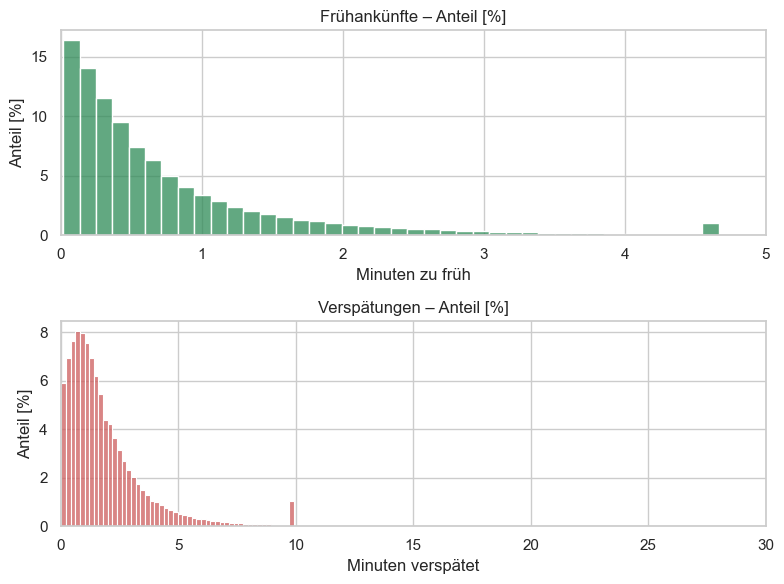

In [22]:
neg = (-x[x<0]).astype(float)  # Minuten zu früh (als positive Werte)
pos = ( x[x>0]).astype(float)

def p99(s): return float(np.percentile(s,99)) if len(s) else 0.0
neg_max, pos_max = p99(neg), p99(pos)

fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=False)

ax = axes[0]
if len(neg):
    sns.histplot(neg.clip(0,neg_max), bins=40, stat="percent", color="seagreen", ax=ax)
    ax.set_xlim(0, max(5,neg_max)); ax.set_title("Frühankünfte – Anteil [%]")
    ax.set_xlabel("Minuten zu früh"); ax.set_ylabel("Anteil [%]")
else:
    ax.text(0.5,0.5,"Keine Frühankünfte",ha="center",va="center",transform=ax.transAxes); ax.axis("off")

ax = axes[1]
if len(pos):
    sns.histplot(pos.clip(0,pos_max), bins=50, stat="percent", color="indianred", ax=ax)
    ax.set_xlim(0, max(30,pos_max)); ax.set_title("Verspätungen – Anteil [%]")
    ax.set_xlabel("Minuten verspätet"); ax.set_ylabel("Anteil [%]")
else:
    ax.text(0.5,0.5,"Keine positiven Verspätungen",ha="center",va="center",transform=ax.transAxes); ax.axis("off")

plt.tight_layout(); plt.show()

**Interpretation:**

Hier werden die Daten nach dem Vorzeichen der Zufallsvariablen getrennt:
Negative Werte (zu früh) und positive Werte (zu spät).
Das entspricht einer Zerlegung einer Verteilung in Teilbereiche, um asymmetrische Effekte besser zu erkennen.

Durch getrennte Histogramme in Prozentdarstellung wird sichtbar, wie häufig Frühankünfte im Vergleich zu Verspätungen auftreten.
Statistisch ist das eine Analyse der Verteilungsform – ob die Masse der Werte links (zu früh) oder rechts (zu spät) konzentriert ist.

Diese Trennung hat auch praktische Bedeutung:
Frühankünfte sind für Fahrgäste oft genauso problematisch wie Verspätungen, aber sie wirken entgegengesetzt auf den Mittelwert.
Durch die Trennung werden gegenteilige Effekte sichtbar, die sonst die Statistik verzerren würden.

**Theoretische Verteilungen (Normal/Lognormal/Exponential)**

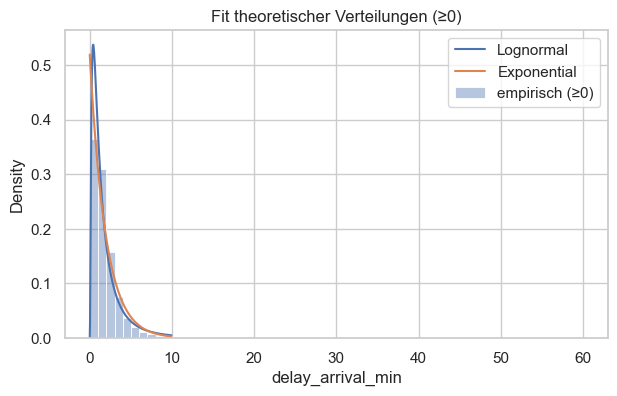

KS Normal (alle Werte): KstestResult(statistic=np.float64(0.2790412070573265), pvalue=np.float64(0.0), statistic_location=np.float64(-0.6666666666666666), statistic_sign=np.int8(-1))
KS Lognormal (≥0): KstestResult(statistic=np.float64(0.06518404697780017), pvalue=np.float64(0.0), statistic_location=np.float64(0.9), statistic_sign=np.int8(-1))
KS Exponential (≥0): KstestResult(statistic=np.float64(0.0706608983250322), pvalue=np.float64(0.0), statistic_location=np.float64(0.5333333333333333), statistic_sign=np.int8(-1))


In [24]:
from scipy import stats

# Normal-Fit auf allen Werten
fit_norm = stats.norm.fit(x)

# Für Lognormal/Exponential nur nicht-negative Werte
pos = x[x > 0].copy()  # nur strikt positive Werte (0 ausgeschlossen)
if len(pos) > 10:      # mind. 10 Werte für robusten Fit
    try:
        fit_logn = stats.lognorm.fit(pos, floc=0)  # klassische Form
        fit_exp  = stats.expon.fit(pos, floc=0)

        xx = np.linspace(0, np.percentile(pos,99), 300)
        plt.figure(figsize=(7,4))
        sns.histplot(pos.clip(0,60), bins=60, stat="density", alpha=0.4, label="empirisch (≥0)")
        plt.plot(xx, stats.lognorm.pdf(xx, *fit_logn), label="Lognormal")
        plt.plot(xx, stats.expon.pdf(xx, *fit_exp),   label="Exponential")
        plt.legend()
        plt.title("Fit theoretischer Verteilungen (≥0)")
        plt.show()

        print("KS Normal (alle Werte):", stats.kstest(x,'norm',  args=fit_norm))
        print("KS Lognormal (≥0):",     stats.kstest(pos,'lognorm',args=fit_logn))
        print("KS Exponential (≥0):",   stats.kstest(pos,'expon',  args=fit_exp))

    except Exception as e:
        print("Fit fehlgeschlagen:", e)
else:
    print("Zu wenige oder ungeeignete Werte für Lognormal/Exponential-Fit.")

### Interpretation: theoretische Verteilungen

Die empirischen Verspätungen lassen sich deutlich besser durch eine **lognormale Verteilung** als durch eine Normal- oder Exponentialverteilung beschreiben.
Dies zeigt sich daran, dass die lognormale Dichtekurve das beobachtete Histogramm eng nachzeichnet, während die anderen Modelle entweder zu flach oder zu steil sind.

Statistisch bedeutet das, dass Verspätungen keine symmetrischen Zufallsschwankungen darstellen, sondern das Ergebnis vieler kleiner, **multiplikativ wirkender Prozesse** sind.
Kleine Verzögerungen sind häufig, große selten, aber möglich – genau das Verhalten, das eine lognormale Verteilung beschreibt.

Damit lässt sich erklären, warum der Mittelwert größer ist als der Median und warum Ausreißer auf der rechten Seite (große Verspätungen) dominieren.
In der Praxis kann dieses Modell genutzt werden, um **Wahrscheinlichkeiten für starke Verspätungen** zu schätzen oder **realistische Simulationsmodelle** zu entwickeln.